In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
import missingno as msno

warnings.filterwarnings('ignore')

In [134]:
# Все библиотеки

import pandas as pd
from scipy.stats import ttest_ind, levene, mannwhitneyu,shapiro, \
    f_oneway, kruskal, chi2_contingency, fisher_exact
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import pingouin as pg

In [265]:
def norm(x: np.ndarray) -> bool:
    return stats.shapiro(x)[1] > 0.05


def correlation_ratio(categorical_series, numerical_series):
    categories = categorical_series.unique()
    total_mean = numerical_series.mean()

    ss_between = sum(len(numerical_series[categorical_series == category]) *
                     (numerical_series[categorical_series == category].mean() - total_mean) ** 2
                     for category in categories)

    ss_total = sum((numerical_series - total_mean) ** 2)

    eta_squared = ss_between / ss_total if ss_total != 0 else 0

    return np.sqrt(eta_squared)


def corr_matrix(df: pd.DataFrame, numeric: list[str], nominal: list[str]):
    cols = numeric + nominal
    corr_df = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_df.loc[col1, col2] = 1.0
            elif col1 in numeric and col2 in numeric:
                norm1 = norm(df[col1].dropna().values)
                norm2 = norm(df[col2].dropna().values)
                if norm1 and norm2:
                    corr_value, _ = stats.pearsonr(df[col1].dropna(), df[col2].dropna())
                else:
                    corr_value, _ = stats.spearmanr(df[col1].dropna(), df[col2].dropna())
                corr_df.loc[col1, col2] = corr_value
                corr_df.loc[col2, col1] = corr_value
            elif col1 in nominal and col2 in nominal:
                contingency_table = pd.crosstab(df[col1], df[col2])
                _, p, _, _ = stats.chi2_contingency(contingency_table)
                corr_df.loc[col1, col2] = p
                corr_df.loc[col2, col1] = p
            else:
                num_col, cat_col = (col1, col2) if col1 in numeric else (col2, col1)
                corr_value = correlation_ratio(df[cat_col], df[num_col])
                corr_df.loc[col1, col2] = corr_value
                corr_df.loc[col2, col1] = corr_value

    corr_df = corr_df.astype(float)


    plt.figure(figsize=(10, 8))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap=cmap, center=0, linewidths=0.5)
    plt.title("Матрица корреляции")
    plt.show()

    return corr_df


def IQR_outliers_remove(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    res = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        res[(column, 1)] = Q1
        res[(column, 3)] = Q3

    for column in columns:
        Q1 = res[(column, 1)]
        Q3 = res[(column, 3)]
        IQR = Q3 - Q1
        df = df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]
    return df


def plot_boxplots(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    plt.figure(figsize=(len(numeric_columns) * 4, 6))
    df[numeric_columns].boxplot(rot=45)
    plt.title("Boxplots for Numeric Columns")
    plt.show()


def plot_hist(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    plt.figure(figsize=(len(numeric_columns) * 4, 6))
    df[numeric_columns].hist()
    plt.title("Hist for Numeric Columns")
    plt.show()


In [81]:
df = pd.read_excel("Датасет дано (1) (1).xlsx")
df.columns = df.columns.str.lower().str.replace(" ", "_")

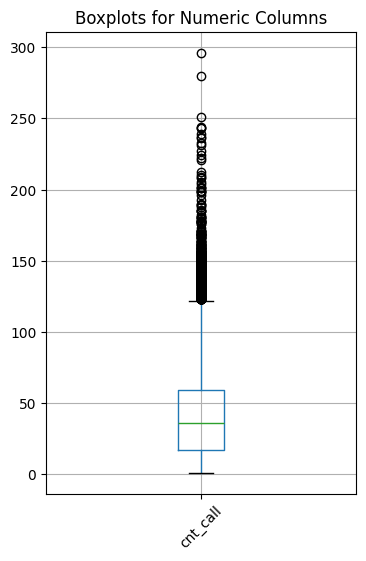

In [23]:
plot_boxplots(df[df['cnt_call'] != 0][['cnt_call']])

In [82]:
df['break_razl'] = abs(df['break_plan'] - df['break_fact'])
df['gender'] = (df['gender_desc'] == 'Мужчина').astype(int)

In [79]:
nominal = ['gender']
numberic = ['kpd', 'avail_fact', 'work_time']

In [250]:
df['kpd'] = (df['useful_chats_fact'] + df['useful_calls_fact'] + df['avail_calls_fact'] + df['avail_chats_fact'] + df['avail_chat_call_fact'] + df["education_fact"] + df["additional_fact"]) / df["all_smena_plan"]
df = df[df['kpd'] != ]

In [262]:
df_new = IQR_outliers_remove(df[df['emp_type'] == 'ТК'], ['kpd'])

In [263]:
print(df[df['emp_type'] == 'ТК'].shape[0] - df_new.shape[0])

50291


In [264]:
df_new

,calendar_dt,id_employee,useful_calls_fact,useful_chats_fact,avail_calls_fact,avail_chats_fact,avail_chat_call_fact,break_fact,education_fact,additional_fact,...,residential_district_nm,residential_city_nm,residential_state_nm,residential_settlement_nm,grafik,cnt_call,dlg_time_call,cnt_chat,dlg_time_chat,kpd
4,2024-09-20,34f30cdf1ab7f0195a74ef15963c29a5,1426,30649,184,2119,0,6028,0,2827,...,NaN,г Ставрополь,Ставропольский край,NaN,2/2,4.0,540.0,258.0,51885.0,0.861227
5,2024-09-20,7097e2b5986ce498bb868778e4a9ea41,0,19115,0,8947,0,4723,0,6,...,NaN,г Миасс,Челябинская обл,NaN,5/2,0.0,0.0,106.0,22087.0,0.866296
6,2024-12-25,2c2351a37b67acb9bf6f24bda28ad0f5,0,14327,0,180,0,1784,0,0,...,NaN,г Краснодар,Краснодарский край,NaN,4,0.0,0.0,88.0,17896.0,0.895494
7,2024-12-25,4d2368a248400e3ac8c2f83b7966168a,9303,83,25498,0,0,5988,0,2310,...,NaN,г Санкт-Петербург,г Санкт-Петербург,NaN,2/2,22.0,7378.0,1.0,82.0,0.860972
9,2024-10-22,f48906ad14d2dec3a72cfd97b2448828,0,2792,0,327,0,691,0,1,...,NaN,NaN,г Москва,NaN,2/2,0.0,0.0,17.0,3440.0,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170765,2024-12-11,eddc48ff92b80c2d6e776db00689f161,10890,0,3507,0,0,1799,0,2,...,NaN,г Ростов-на-Дону,Ростовская обл,NaN,4,35.0,9835.0,0.0,0.0,0.888827
170767,2024-09-06,837862f086a582355eb9c58c1c46a6b1,0,30326,0,18,0,7802,5499,0,...,NaN,NaN,г Санкт-Петербург,п Стрельна,Ночь,0.0,0.0,65.0,63232.0,0.829699
170768,2024-09-06,27ef91fbecdac19c26efeca07cfb0266,0,15003,0,52,0,1798,0,2,...,NaN,г Санкт-Петербург,г Санкт-Петербург,NaN,4,0.0,0.0,85.0,25714.0,0.929444
170769,2024-12-11,a759ab6d5b8c80f3f6fad30a7b8ec88a,0,35093,0,2279,0,6022,0,0,...,NaN,г Мытищи,Московская обл,NaN,2/2,0.0,0.0,246.0,51415.0,0.865093


In [153]:
df_new2 = IQR_outliers_remove(df, ['kpd'])
df_new2 = df_new2[df_new2['emp_type'] == 'ТК']

In [154]:
df_new2

,calendar_dt,id_employee,useful_calls_fact,useful_chats_fact,avail_calls_fact,avail_chats_fact,avail_chat_call_fact,break_fact,education_fact,additional_fact,...,residential_state_nm,residential_settlement_nm,grafik,cnt_call,dlg_time_call,cnt_chat,dlg_time_chat,break_razl,gender,kpd
0,2024-10-22,b85a5824cc3411e3429bd49054ffcc17,1225,0,2542,0,0,0,27598,0,...,Пермский край,NaN,5/2,3.0,497.0,NaN,NaN,4800,1,1.136413
2,2024-09-20,3506d80afbdc2f1ddcee2ce65e7d82ee,0,21235,0,372,0,4208,0,1,...,Респ Татарстан,NaN,5/2,NaN,NaN,136.0,31416.0,592,0,0.782862
3,2024-12-25,a497350c6c8542c1e79ae2b83e6c782d,11483,27466,3,130,0,4810,0,1,...,Челябинская обл,NaN,5/2,35.0,8223.0,78.0,39998.0,10,1,1.416014
5,2024-09-20,7097e2b5986ce498bb868778e4a9ea41,0,19115,0,8947,0,4723,0,6,...,Челябинская обл,NaN,5/2,NaN,NaN,106.0,22087.0,77,0,1.016739
10,2024-12-25,b2dfb1e62ae8960cf31403909d1a6a01,0,27810,0,156,0,4798,0,1,...,Самарская обл,NaN,5/2,NaN,NaN,274.0,55704.0,2,1,1.013261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170759,2024-11-20,f4f48e1b07c0d0f80e014f9a2abe878e,5,32996,0,673,0,5979,0,0,...,г Москва,NaN,2/2,NaN,NaN,150.0,55931.0,21,0,1.002202
170760,2024-11-20,95b777473a4417b754b050fc225afce7,0,27610,0,188,0,4644,0,1,...,г Москва,NaN,5/2,NaN,NaN,84.0,52688.0,156,1,1.007174
170761,2024-11-20,687064c51f27a5767241854be795c089,24196,0,3907,0,0,4625,0,2,...,г Москва,дп Кокошкино,5/2,57.0,21781.0,NaN,NaN,175,0,1.018225
170771,2024-11-09,96c133f5920b318f0d2fa0008ef77196,0,0,3869,0,0,4937,0,368,...,Респ Крым,пгт Коктебель,5/2,NaN,NaN,NaN,NaN,137,0,0.140181


In [111]:
df_new2['grafik'].value_counts()

grafik
5/2            51948
2/2             2301
Нет графика      744
Ночь             720
35 часов         459
4                367
36 часов          65
Name: count, dtype: int64

In [115]:
get_dummies = pd.get_dummies(df_new2[['business_line', 'gender_desc', 'grafik']])
pd.concat([df_new2, get_dummies], axis=1)

,calendar_dt,id_employee,useful_calls_fact,useful_chats_fact,avail_calls_fact,avail_chats_fact,avail_chat_call_fact,break_fact,education_fact,additional_fact,...,business_line_Страховая,gender_desc_Женщина,gender_desc_Мужчина,grafik_2/2,grafik_35 часов,grafik_36 часов,grafik_4,grafik_5/2,grafik_Нет графика,grafik_Ночь
0,2024-10-22,b85a5824cc3411e3429bd49054ffcc17,1225,0,2542,0,0,0,27598,0,...,True,False,True,False,False,False,False,True,False,False
2,2024-09-20,3506d80afbdc2f1ddcee2ce65e7d82ee,0,21235,0,372,0,4208,0,1,...,False,True,False,False,False,False,False,True,False,False
3,2024-12-25,a497350c6c8542c1e79ae2b83e6c782d,11483,27466,3,130,0,4810,0,1,...,False,False,True,False,False,False,False,True,False,False
5,2024-09-20,7097e2b5986ce498bb868778e4a9ea41,0,19115,0,8947,0,4723,0,6,...,False,True,False,False,False,False,False,True,False,False
10,2024-12-25,b2dfb1e62ae8960cf31403909d1a6a01,0,27810,0,156,0,4798,0,1,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170759,2024-11-20,f4f48e1b07c0d0f80e014f9a2abe878e,5,32996,0,673,0,5979,0,0,...,False,True,False,True,False,False,False,False,False,False
170760,2024-11-20,95b777473a4417b754b050fc225afce7,0,27610,0,188,0,4644,0,1,...,False,False,True,False,False,False,False,True,False,False
170761,2024-11-20,687064c51f27a5767241854be795c089,24196,0,3907,0,0,4625,0,2,...,False,True,False,False,False,False,False,True,False,False
170771,2024-11-09,96c133f5920b318f0d2fa0008ef77196,0,0,3869,0,0,4937,0,368,...,False,True,False,False,False,False,False,True,False,False


In [121]:
df_new2[['business_line', 'napravlenie', 'gender', 'kpd']].groupby(by=['business_line', 'napravlenie', 'gender']).count()

kpd
business_line         napravlenie             gender       
Mobile                Mob 1ая линия           0        1570
                                              1         905
Premium Банк          Saving Premium Банк     0           5
                      Support Premium Банк    0        1357
                                              1         573
SME                   Guard                   0          17
                      ME                      0           1
                                              1         159
                      SE                      0        3665
                                              1        1772
                      SE EACQ                 0         338
                                              1         198
                      SE TACQ                 0         410
                                              1         156
                      SE VED                  0         129
                                              1          51
                      Бухгалтерия SME         0         944
                                              1          86
                      Партнеры                0         190
Депозитные продукты   Вклады                  0         528
                                              1         644
                      Дебетовые карты         0       14332
                                              1        7957
                      Кобренды                0         299
                                              1         246
                      Нерезиденты             0        1088
                                              1         446
                      Семейный банк           0         363
                                              1         391
Инвестиции            Инвестиции              0        1598
                                              1        1555
Кредитные продукты    Беззалоговые ПК         0         771
                                              1         528
                      Залоговые ПК            0         706
                                              1         882
                      Кредитные карты         0        3934
                                              1        2224
Кросс-функции         Антифрод                0         819
                                              1         467
                      Другое                  0         556
                                              1         393
                      Непродуктовые обращения 0         430
                                              1         371
Нефинансовые продукты Lifestyle               0         274
                                              1          97
                      Travel                  0         490
Страховая             Ins 1ая линия           0         732
                                              1         404
                      Ins Решатели            0         498
                                              1          55

In [122]:
df_new2['kpd'].corr(df_new2['break_fact'])

np.float64(-0.16427165711126465)

In [189]:
for uniq in df_new2['business_line'].unique():
    now = df_new2[df_new2['business_line'] == uniq]
    now['time_to_work'] = now['work_activity_plan'] + now['education_plan']
    print(f'{uniq} : ', now['time_to_work'].corr(df['kpd']), "           строк", now.shape[0])


Страховая :  -0.05746269939887574            строк 1689
Депозитные продукты :  -0.532001553204846            строк 25987
Инвестиции :  -0.2003670334411555            строк 3155
Кредитные продукты :  -0.34298661978000905            строк 8988
SME :  -0.08302989128195294            строк 7776
Mobile :  -0.4981331359369548            строк 2469
Premium Банк :  -0.053687911581883935            строк 1937
Кросс-функции :  -0.016314489266586657            строк 2623
Нефинансовые продукты :  -0.03755301339063272            строк 852


In [185]:
now = df_new2
now['time_to_work'] = now['work_activity_plan'] + now['education_plan']
now['time_to_work'].corr(df['kpd'])

np.float64(-0.3639333967354771)

In [236]:
now = df[df['grafik'].isin(['2/2', '5/2'])].dropna(subset=['kpd'])

now['2/2'] = (now['grafik'] == '2/2').astype(int)

kpd_group1 = now[now['2/2'] == 1][now['kpd'] < 1000]['kpd']
kpd_group2 = now[now['2/2'] == 0][now['kpd'] < 1000]['kpd']

t_stat, p_value = stats.mannwhitneyu(kpd_group1, kpd_group2, alternative='two-sided')

print(f"U-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")

U-статистика: 865812186.5000, p-значение: 0.0000


In [266]:
print("Медианы:")
print('2: ', kpd_group2.median()*100)
print('1: ', kpd_group1.median()*100)

Медианы:
2:  85.46410891089108
1:  86.26129256428075


In [240]:
print(norm(kpd_group1), norm(kpd_group2))

False False


In [244]:
now[now['kpd'] < 1000000000]['kpd'].max()

np.float64(19242.333333333332)

In [279]:
for i in df['gender_desc'].unique():
    now = df[df['gender_desc'] == i][df['grafik'].isin(['2/2', '5/2'])].dropna(subset=['kpd'])

    now['2/2'] = (now['grafik'] == '2/2').astype(int)

    kpd_group1 = now[now['2/2'] == 1][now['kpd'] < 1000]['kpd']
    kpd_group2 = now[now['2/2'] == 0][now['kpd'] < 1000]['kpd']
    if len(kpd_group1) != 0 and 0 != len(kpd_group2):
        t_stat, p_value = stats.mannwhitneyu(kpd_group1, kpd_group2, alternative='two-sided')
        print(f"{i}, {j} : p-значение: {p_value:.4f}, кол-во: {now.shape[0]}")

Мужчина, Travel : p-значение: 0.0000, кол-во: 32348
Женщина, Travel : p-значение: 0.0000, кол-во: 56367
